<div align="center">
<font color=0F5298 size=5>
Token-level Toxicity Classifier Using BiLSTM-CRF
</font> <br>

<font color=2565AE size=2>
 Natural Language Processing Course - Task 4
</font> <br>

<font color=2565AE size=3>
 Sharif University of Technology - Fall 2023
</font> <br>
<font color=3C99D size=4>
 Contributers: Sina Namazi - Erfan Sadrayieh - Benyamin Maleki
</font> <br>

<font color=3C99D size=4>
STU-Ids (in order): 400110154- 99101835 - 99102286
</font>
</div>


**Firtst, we need to install the necessary libraries.**

In [1]:
# Install neccessary libraries
!pip install gdown
!pip install seaborn

**In the next cell we are going to import the necessary libraries.**

In [2]:
# Import necessary libraries
# Tools
import gdown
from tqdm import tqdm

# Base
import pandas as pd
import numpy as np
from ast import literal_eval

# Torch
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.optim as optim

torch.manual_seed(42)

# sklearn
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

# Visualization
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

**The device that is going to be used throughout the notebook is chosen in the next cell.**

In [3]:
# Downloading the dataset
gdown.download(url=f"https://drive.google.com/uc?id=1fs7gIKvNl_GlX9vFUdtMRFWWYeqI3muQ", output='toxic_spans.csv')

Downloading...
From: https://drive.google.com/uc?id=1fs7gIKvNl_GlX9vFUdtMRFWWYeqI3muQ
To: /Users/sina/Sem-4/nlp/HW4/toxic_spans.csv
100%|██████████| 10.6M/10.6M [00:06<00:00, 1.66MB/s]


'toxic_spans.csv'

In [4]:
# Loading the dataset
df = pd.read_csv('toxic_spans.csv')
df = df[['probability', 'type', 'text_of_post']]
df['probability'] = df['probability'].apply(literal_eval)
df['type'] = df['type'].apply(literal_eval)

**Functions used in this notebook are going to be defined in the next cell.**

**These functions include:**

- ```merge_overlapping_ranges()```: This functions is used for extracting data from the csv file and handling ranges of characters for preprocessing purposes.

- ```argmax()```: This functions outputs the argmax of a vector.


- ```prepare_sequence()```: This functions replaces each token in a sequence with its token index.


- ```log_sum_exp()```: This functions computes log sum exp in a numerically stable way for the forward algorithm.


- ```print_metrics()```: This functions is used at the end for evaluating our model and reporting different metrics on different splits of our data.

- ```plot_confusion_matrix()```: This functions is used at the end for evaluating our model on different splits of our data and making the confusion matrix.


In [5]:
# Functions needed for this project:

# merge_overlapping_ranges is used for extracting data from
# the csv file and handling ranges of characters for preprocessing the data
def merge_overlapping_ranges(tuples):
    sorted_tuples = sorted(tuples, key=lambda x: x[0])

    merged_ranges = []
    current_range = sorted_tuples[0]

    for start, end in sorted_tuples[1:]:
        if start <= current_range[1]:
            current_range = (current_range[0], end)
        else:
            merged_ranges.append(current_range)
            current_range = (start, end)

    merged_ranges.append(current_range)
    return merged_ranges

# outputs the argmax of a vector
def argmax(vec):
    _, idx = torch.max(vec, 1)
    return idx.item()

# replaces each token in a sequence with its token index
def prepare_sequence(seq, to_ix):
    idxs = []
    for w in seq:
        if w not in to_ix:
            idxs.append(to_ix['<UNK>'])
        else:
            idxs.append(to_ix[w])
    return torch.tensor(idxs, dtype=torch.long)


# Compute log sum exp in a numerically stable way for the forward algorithm
def log_sum_exp(vec):
    max_score = vec[0, argmax(vec)]
    max_score_broadcast = max_score.view(1, -1).expand(1, vec.size()[1])
    return max_score + \
        torch.log(torch.sum(torch.exp(vec - max_score_broadcast)))

# print_metrics is used at the end for evaluating our model and 
# reporting different metrics on different splits of our data
def print_metrics(model, dataset, split):
    predictions = []
    true_labels = []
    with torch.no_grad():
        for i in range(len(dataset[split])):
            sentence = dataset[split][i][0]
            sentence_in = prepare_sequence(sentence, word_to_ix)
            score, tag_seq = model(sentence_in)
            for j in range(len(tag_seq)):
                predictions.append(tag_seq[j])
                true_labels.append(tag_to_ix[dataset[split][i][1][j]])
    print(f"Model Metrics for {split} split")
    print(classification_report(true_labels, predictions, target_names = label_list))

# plot_confusion_matrix is used at the end for evaluating our model 
# on different splits of our data and making the confusion matrix
def plot_confusion_matrix(model, dataset, split):
    predictions = []
    true_labels = []
    with torch.no_grad():
        for i in range(len(dataset[split])):
            sentence = dataset[split][i][0]
            sentence_in = prepare_sequence(sentence, word_to_ix)
            score, tag_seq = model(sentence_in)
            for j in range(len(tag_seq)):
                predictions.append(tag_seq[j])
                true_labels.append(tag_to_ix[dataset[split][i][1][j]])

    cm = confusion_matrix(true_labels, predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                cbar=False, xticklabels=label_list, yticklabels=label_list)
    plt.title('Comfusion Matrix for ' + split + ' split')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()





START_TAG = "<START>"
STOP_TAG = "<STOP>"

# Mapping between labels and their ids
tag_to_ix = {'none': 0, 'insult': 1, 'threat': 2,
              'identity based attack': 3, 'profane/obscene': 4,
              'other toxicity':5,
              START_TAG: 6, STOP_TAG: 7
              }

ix_to_tag = {0: 'none', 1: 'insult', 2: 'threat',
                3: 'identity based attack', 4: 'profane/obscene',
                5: 'other toxicity',
                7: START_TAG, 7: STOP_TAG
                }
label_list = ['none', 'insult', 'threat', 'identity based attack', 'profane/obscene', 'other toxicity']


**In the following cell we are going to to the first step of preprocessing on our data and extract the words and their labels from the dataframe as it was explaind in the documentation of this task.**

In [6]:
# Extracting the data from the dataframe
data = []
for index, row in df.iterrows():
    sample = {'tokens': [], 'tags': []}
    prob = row['probability']
    typ = row['type']
    text = row['text_of_post']
    text = text.lower()
    if typ == {}:
        label = 'none'
    else:
        label = max(typ, key=typ.get)
    label = tag_to_ix[label]
    if label == 'none':
        tokens = text.split()
        token_tags = ['none'] * len(tokens)
        sample['tokens'] = tokens
        sample['tags'] = token_tags
        data.append(sample)
        continue
    else:
        tuples = []
        for key, value in prob.items():
            if value >= 0.5:
                tuples.append((key[0], key[1]))
        if len(tuples) == 0:
            tokens = text.split()
            token_tags = ['none'] * len(tokens)
            sample['tokens'] = tokens
            sample['tags'] = token_tags
            data.append(sample)
            continue
        else:
            tuples = merge_overlapping_ranges(tuples)
            start_index = 0
            for tuple in tuples:
                start = tuple[0]
                end = tuple[1]
                before = text[start_index:start]
                before = before.split()
                for i in range(len(before)):
                    sample['tokens'].append(before[i])
                    sample['tags'].append('none')
                inside = text[start:end]
                inside = inside.split()
                for i in range(len(inside)):
                    sample['tokens'].append(inside[i])
                    sample['tags'].append(ix_to_tag[label])
                start_index = end
            after = text[end:]
            after = after.split()
            for i in range(len(after)):
                sample['tokens'].append(after[i])
                sample['tags'].append('none')
    data.append(sample)

**In the following cell we are going to split the data into train, validation, and test sets.**


**These three comprise 80%, 10%, and 10% of the total data respectively.**

**Note that we are using a seed for this random splitting so we can get the same result when we are splitting our data for the other method.**

In [7]:
# Splitting the data into Train, Validation, and Test sets
train, temp = train_test_split(data, test_size=0.2, random_state=42)
validation, test = train_test_split(temp, test_size=0.5, random_state=42)

dataset = {'train': [], 'validation': [], 'test': []}

for i in range(len(train)):
    sample = (train[i]['tokens'], train[i]['tags'])
    dataset['train'].append(sample)

for i in range(len(validation)):
    sample = (validation[i]['tokens'], validation[i]['tags'])
    dataset['validation'].append(sample)

for i in range(len(test)):
    sample = (test[i]['tokens'], test[i]['tags'])
    dataset['test'].append(sample)


word_to_ix = {'<UNK>': 0}
for sentence, tags in dataset['train']:
    for word in sentence:
        if word not in word_to_ix:
            word_to_ix[word] = len(word_to_ix)

In the following cell we are going to write our BiLSTM_CRF model.

The code for this model was written by Robert Guthrie and was published on pytorch documentations.

You can find the explanation for this model on here [pytorch.org](https://pytorch.org/tutorials/beginner/nlp/advanced_tutorial.html)

In [8]:
class BiLSTM_CRF(nn.Module):

    def __init__(self, vocab_size, tag_to_ix, embedding_dim, hidden_dim):
        super(BiLSTM_CRF, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.tag_to_ix = tag_to_ix
        self.tagset_size = len(tag_to_ix)

        self.word_embeds = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim // 2,
                            num_layers=1, bidirectional=True)

        # Maps the output of the LSTM into tag space.
        self.hidden2tag = nn.Linear(hidden_dim, self.tagset_size)

        # Matrix of transition parameters.  Entry i,j is the score of
        # transitioning *to* i *from* j.
        self.transitions = nn.Parameter(
            torch.randn(self.tagset_size, self.tagset_size))

        # These two statements enforce the constraint that we never transfer
        # to the start tag and we never transfer from the stop tag
        self.transitions.data[tag_to_ix[START_TAG], :] = -10000
        self.transitions.data[:, tag_to_ix[STOP_TAG]] = -10000

        self.hidden = self.init_hidden()

    def init_hidden(self):
        return (torch.randn(2, 1, self.hidden_dim // 2),
                torch.randn(2, 1, self.hidden_dim // 2))

    def _forward_alg(self, feats):
        # Do the forward algorithm to compute the partition function
        init_alphas = torch.full((1, self.tagset_size), -10000.)
        # START_TAG has all of the score.
        init_alphas[0][self.tag_to_ix[START_TAG]] = 0.

        # Wrap in a variable so that we will get automatic backprop
        forward_var = init_alphas

        # Iterate through the sentence
        for feat in feats:
            alphas_t = []  # The forward tensors at this timestep
            for next_tag in range(self.tagset_size):
                # broadcast the emission score: it is the same regardless of
                # the previous tag
                emit_score = feat[next_tag].view(
                    1, -1).expand(1, self.tagset_size)
                # the ith entry of trans_score is the score of transitioning to
                # next_tag from i
                trans_score = self.transitions[next_tag].view(1, -1)
                # The ith entry of next_tag_var is the value for the
                # edge (i -> next_tag) before we do log-sum-exp
                next_tag_var = forward_var + trans_score + emit_score
                # The forward variable for this tag is log-sum-exp of all the
                # scores.
                alphas_t.append(log_sum_exp(next_tag_var).view(1))
            forward_var = torch.cat(alphas_t).view(1, -1)
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        alpha = log_sum_exp(terminal_var)
        return alpha

    def _get_lstm_features(self, sentence):
        self.hidden = self.init_hidden()
        embeds = self.word_embeds(sentence).view(len(sentence), 1, -1)
        lstm_out, self.hidden = self.lstm(embeds, self.hidden)
        lstm_out = lstm_out.view(len(sentence), self.hidden_dim)
        lstm_feats = self.hidden2tag(lstm_out)
        return lstm_feats

    def _score_sentence(self, feats, tags):
        # Gives the score of a provided tag sequence
        score = torch.zeros(1)
        tags = torch.cat([torch.tensor([self.tag_to_ix[START_TAG]], dtype=torch.long), tags])
        for i, feat in enumerate(feats):
            score = score + \
                self.transitions[tags[i + 1], tags[i]] + feat[tags[i + 1]]
        score = score + self.transitions[self.tag_to_ix[STOP_TAG], tags[-1]]
        return score

    def _viterbi_decode(self, feats):
        backpointers = []

        # Initialize the viterbi variables in log space
        init_vvars = torch.full((1, self.tagset_size), -10000.)
        init_vvars[0][self.tag_to_ix[START_TAG]] = 0

        # forward_var at step i holds the viterbi variables for step i-1
        forward_var = init_vvars
        for feat in feats:
            bptrs_t = []  # holds the backpointers for this step
            viterbivars_t = []  # holds the viterbi variables for this step

            for next_tag in range(self.tagset_size):
                # next_tag_var[i] holds the viterbi variable for tag i at the
                # previous step, plus the score of transitioning
                # from tag i to next_tag.
                # We don't include the emission scores here because the max
                # does not depend on them (we add them in below)
                next_tag_var = forward_var + self.transitions[next_tag]
                best_tag_id = argmax(next_tag_var)
                bptrs_t.append(best_tag_id)
                viterbivars_t.append(next_tag_var[0][best_tag_id].view(1))
            # Now add in the emission scores, and assign forward_var to the set
            # of viterbi variables we just computed
            forward_var = (torch.cat(viterbivars_t) + feat).view(1, -1)
            backpointers.append(bptrs_t)

        # Transition to STOP_TAG
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        best_tag_id = argmax(terminal_var)
        path_score = terminal_var[0][best_tag_id]

        # Follow the back pointers to decode the best path.
        best_path = [best_tag_id]
        for bptrs_t in reversed(backpointers):
            best_tag_id = bptrs_t[best_tag_id]
            best_path.append(best_tag_id)
        # Pop off the start tag (we dont want to return that to the caller)
        start = best_path.pop()
        assert start == self.tag_to_ix[START_TAG]  # Sanity check
        best_path.reverse()
        return path_score, best_path

    def neg_log_likelihood(self, sentence, tags):
        feats = self._get_lstm_features(sentence)
        forward_score = self._forward_alg(feats)
        gold_score = self._score_sentence(feats, tags)
        return forward_score - gold_score

    def forward(self, sentence):  # dont confuse this with _forward_alg above.
        # Get the emission scores from the BiLSTM
        lstm_feats = self._get_lstm_features(sentence)

        # Find the best path, given the features.
        score, tag_seq = self._viterbi_decode(lstm_feats)
        return score, tag_seq

**In the following cell we are going to train our model on our specific task.**

In [9]:
EMBEDDING_DIM = 128
HIDDEN_DIM = 128


model = BiLSTM_CRF(len(word_to_ix), tag_to_ix, EMBEDDING_DIM, HIDDEN_DIM)
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-4)


for epoch in tqdm(range(2)):
    for sentence, tags in dataset['train']:
        model.zero_grad()
        sentence_in = prepare_sequence(sentence, word_to_ix)
        targets = torch.tensor([tag_to_ix[t] for t in tags], dtype=torch.long)
        loss = model.neg_log_likelihood(sentence_in, targets)
        loss.backward()
        optimizer.step()
model.eval()

/Users/sina/miniforge3/envs/nlp/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 2/2 [12:10<00:00, 365.06s/it]


BiLSTM_CRF(
  (word_embeds): Embedding(37613, 128)
  (lstm): LSTM(128, 64, bidirectional=True)
  (hidden2tag): Linear(in_features=128, out_features=8, bias=True)
)

**In the following cells we are going to report the model's performance on different splits of data.**

In [10]:
print_metrics(model, dataset, "train")

Model Metrics for train split
                       precision    recall  f1-score   support

                 none       0.99      1.00      0.99    317136
               insult       0.73      0.67      0.70      4895
               threat       0.80      0.06      0.11       141
identity based attack       0.79      0.05      0.09       319
      profane/obscene       0.49      0.10      0.17       357
       other toxicity       0.00      0.00      0.00       135

             accuracy                           0.99    322983
            macro avg       0.63      0.31      0.34    322983
         weighted avg       0.99      0.99      0.99    322983



/Users/sina/miniforge3/envs/nlp/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sina/miniforge3/envs/nlp/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sina/miniforge3/envs/nlp/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [11]:
print_metrics(model, dataset, "validation")

Model Metrics for validation split
                       precision    recall  f1-score   support

                 none       0.99      1.00      0.99     40457
               insult       0.67      0.61      0.64       619
               threat       0.00      0.00      0.00         8
identity based attack       0.00      0.00      0.00        34
      profane/obscene       0.21      0.06      0.09        53
       other toxicity       0.00      0.00      0.00        14

             accuracy                           0.99     41185
            macro avg       0.31      0.28      0.29     41185
         weighted avg       0.99      0.99      0.99     41185



/Users/sina/miniforge3/envs/nlp/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sina/miniforge3/envs/nlp/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sina/miniforge3/envs/nlp/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [12]:
print_metrics(model, dataset, 'test')

Model Metrics for test split
                       precision    recall  f1-score   support

                 none       0.99      1.00      0.99     40802
               insult       0.70      0.61      0.65       625
               threat       0.50      0.20      0.29        15
identity based attack       0.00      0.00      0.00        45
      profane/obscene       0.50      0.05      0.09        59
       other toxicity       0.00      0.00      0.00        15

             accuracy                           0.99     41561
            macro avg       0.45      0.31      0.34     41561
         weighted avg       0.98      0.99      0.99     41561



/Users/sina/miniforge3/envs/nlp/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sina/miniforge3/envs/nlp/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sina/miniforge3/envs/nlp/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


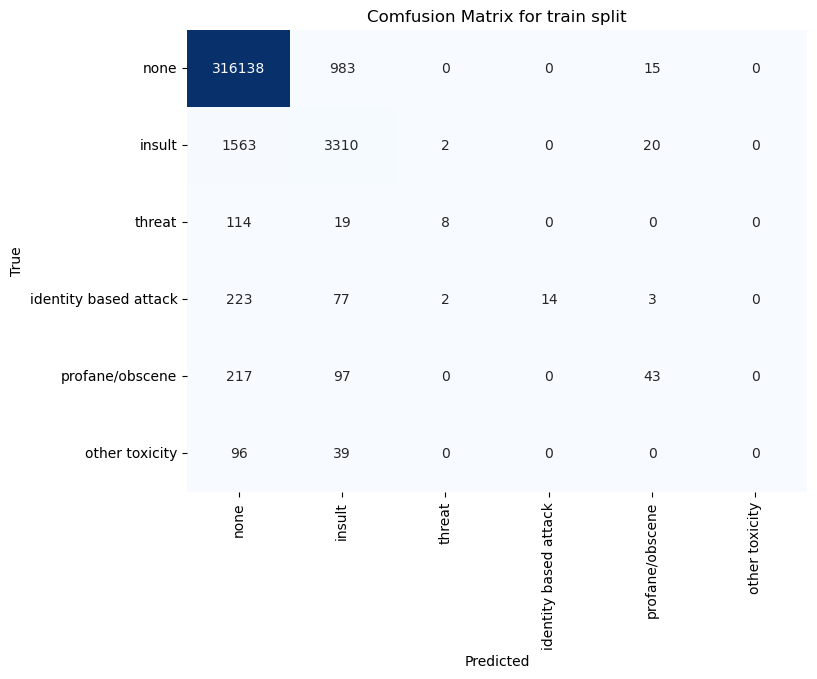

In [13]:
plot_confusion_matrix(model, dataset, "train")

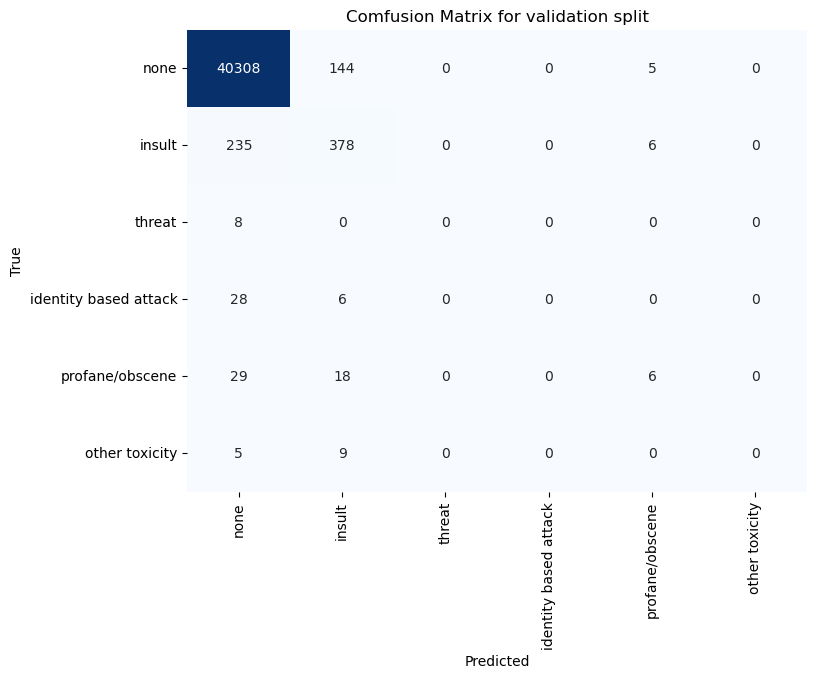

In [14]:
plot_confusion_matrix(model, dataset, "validation")

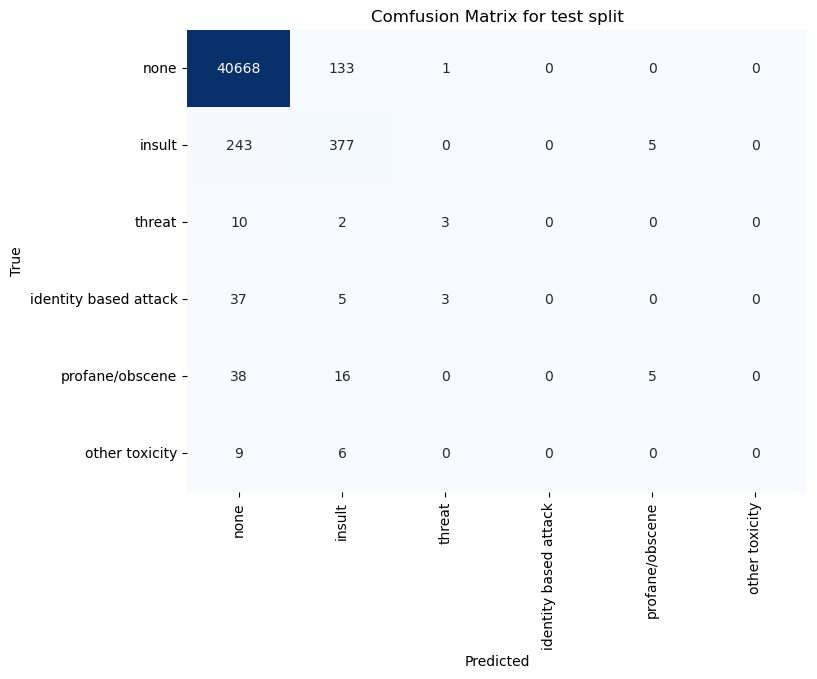

In [15]:
plot_confusion_matrix(model, dataset, "test")

**Playing around with the model:**

(I apologize for the language used in the following examples)

In [49]:
def pipeline(text):
    text = text.lower()
    tokens = text.split()
    sentence_in = prepare_sequence(tokens, word_to_ix)
    score, tag_seq = model(sentence_in)
    tags = [ix_to_tag[i] for i in tag_seq]
    return list(zip(tokens, tags))

In [50]:
sample_text = "I can't stand your stupid face"
print(pipeline(sample_text))

[('i', 'none'), ("can't", 'none'), ('stand', 'none'), ('your', 'none'), ('stupid', 'insult'), ('face', 'none')]


In [51]:
sample_text = "What an idiot"
print(pipeline(sample_text))

[('what', 'none'), ('an', 'none'), ('idiot', 'insult')]


In [67]:
sample_text = "Fuck you asshole"
print(pipeline(sample_text))

[('fuck', 'insult'), ('you', 'insult'), ('asshole', 'insult')]
